In [23]:
from datetime import datetime, timedelta
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.units import units
import matplotlib.pyplot as plt
import metpy.plots as plots
import numpy as np
import metpy.calc as mpcalc

In [24]:
date = datetime(2020, 4, 12, 18)
station = 'JAN'
figX=15
figY=10
dpi=100
drawFiducialLines=True
capeThreshold=250 #J/kg
drawParcelPath=True
shadeCAPE=True
shadeCIN=False
highlightZero=True
highlightDGZ=True

In [25]:
# Load data
df = WyomingUpperAir.request_data(date, station)

# Add units
p = df['pressure'].values * units(df.units['pressure'])
T = df['temperature'].values * units(df.units['temperature'])
Td = df['dewpoint'].values * units(df.units['dewpoint'])
u = df['u_wind'].values * units(df.units['u_wind'])
v = df['v_wind'].values * units(df.units['v_wind'])

In [26]:
# Re-sample wind barb plot
interval = np.logspace(2,3) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval)

# Calculate CAPE
sbcape = mpcalc.surface_based_cape_cin(p, T, Td)[0].magnitude
mlcape = mpcalc.mixed_layer_cape_cin(p, T, Td)[0].magnitude

# Calculate parcel paths
surface_parcel = mpcalc.parcel_profile(p, T[0], Td[0])
surface_parcel_path = mpcalc.parcel_profile(p, T[0], Td[0])
mixed_parcel = mpcalc.mixed_parcel(p, T, Td)
mixed_parcel_path = mpcalc.parcel_profile(p, mixed_parcel[1], mixed_parcel[2])
parcel_path=mixed_parcel_path

<module 'matplotlib.pyplot' from '/home/CarterHumphreys/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

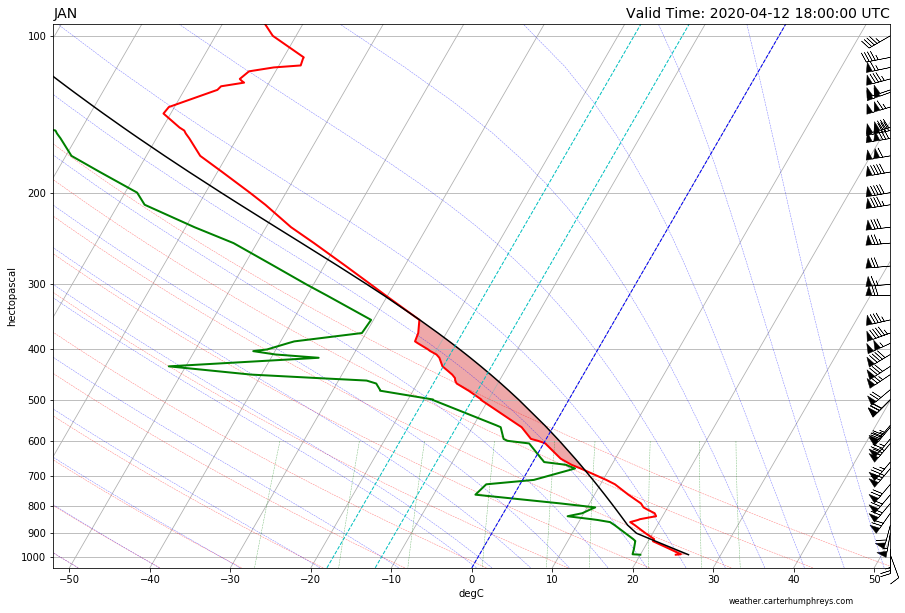

In [27]:
# Draw skew-T
plt.rcParams['savefig.dpi'] = dpi
fig = plt.figure(figsize=(figX, figY))
skew = plots.SkewT(fig)
skew.ax.set_ylim(1050, 95)
skew.ax.set_xlim(-52, 52)
skew.plot(p, T, 'red', linewidth=2)
skew.plot(p, Td, 'green', linewidth=2)
skew.plot_barbs(p[idx], u[idx], v[idx], linewidth=0.5)

# Draw fiducial lines
if drawFiducialLines:
    skew.plot_dry_adiabats(linewidth=0.5, alpha=0.5)
    skew.plot_moist_adiabats(linewidth=0.5, alpha=0.5)
    skew.plot_mixing_lines(linewidth=0.5, alpha=0.5)

if mlcape > capeThreshold:
    #Draw ML parcel path
    if drawParcelPath:
        skew.plot(p, parcel_path, color='black')

    #Shade CAPE and CIN
    if shadeCAPE:
        skew.shade_cape(p, T, parcel_path)
    if shadeCIN:
        skew.shade_cin(p, T, parcel_path)

# Highlight 0°C isotherm
if highlightZero:
    skew.ax.axvline(0, color='b', linestyle='--', linewidth=1.0)

# Highlight DGZ
if highlightDGZ:
    skew.ax.axvline(-12, color='c', linestyle='--', linewidth=1.0)
    skew.ax.axvline(-18, color='c', linestyle='--', linewidth=1.0)

# Plot Title
plt.title(f'{station}', fontsize=14, loc='left')
plt.title(f'Valid Time: {date.strftime("%Y-%m-%d %H:00:00")} UTC', fontsize=14, loc='right')

# Add citation
fig.text(0.75, 0.075, 'weather.carterhumphreys.com', fontsize=8)

# Label Axis
plt.ylabel(p.units)
plt.xlabel(T.units)

plt